# How to perform noise spectroscopy on arbitrary noise channels
**Reconstructing noise spectra using shaped control pulses**

Boulder Opal enables you to characterize and then reconstruct power spectral densities for arbitrary noise processes affecting your system. These power spectral densities can provide useful information for [designing robust controls](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) that improve the performance of the system in the presence of noise. 

In this notebook we show how to characterize and reconstruct noise spectra using Boulder Opal.  

Noise spectroscopy fundamentally relies on performing probe measurements of your quantum system and then inferring information about the system noise from the returned measurement outcomes.  For arbitrary controls this challenge is efficiently enabled by calculating their spectral response using the filter function framework (applicable to D-dimensional Hilbert spaces).  The measurement associated with the $i^{th}$ applied control can be expressed in discretized form as follows:
\begin{align*}
P_i = \sum_{j=1}^N F^i_j S_j \Delta \nu,
\end{align*}
where the filter function of the control $F^i$ and the spectrum $\mathbf{S}$ are sampled with spectral resolution $\Delta \nu = (\nu_{\rm max}-\nu_{\rm min})/N$. 

Spectral reconstruction requires finding the matrix $\mathbf{M}$, such that $\mathbf{P} = \mathbf{M}\mathbf{S}$ and then inverting to find $\mathbf{S}$.  Therefore, appropriate selection of controls enables you to interrogate the spectrum window ($\nu_{\rm min}$,$\nu_{\rm max}$) in great detail by overlapping the filter functions to sample the spectrum as densely as needed.

## Summary workflow

By following these steps, you'll build a spectrum reconstruction technique customized to your needs:
1. Determine probe controls that are sensitive to noise at different frequencies,
2. Collect experimental measurements $\mathbf{P}$, 
3. Construct the mapping $\mathbf{M}$ between measurements $\mathbf{P}$ and the power spectrum $\mathbf{S}$, where $\mathbf{P=MS}$ using the filter-function formalism,
4. Invert the mapping $M$ in order to reconstruct the interrogated section of the spectrum $\mathbf{S} = \mathbf{M^{-1}}\mathbf{P}$.


### 1. Determine probe controls that are sensitive to noise at different frequencies
In principle any set of measurements can be used to probe a noise spectrum.  We provide a framework in which to efficiently define modulated-Gaussian probe controls which give ready access to frequency-resolved information about your system.  The assumption here is that you are able to employ shaped pulses in your system.

The specific set of controls you should employ will be determined by the specific reconstruction at hand.

#### Considerations for efficient spectral sampling.

Let the probe-pulse duration be $T$, the minimum segment duration $t$; generally speaking, the maximum noise frequency to which a characterization pulse is sensitive is $0.5/t$ (the Nyquist frequency). Therefore, to reconstruct a spectrum defined up to some frequency $f_\text{max}$, the minimum segment duration should be chosen as $t\approx 0.5/f_\text{max}$. The bandwidth of each filter function, and thus the resolution of the resulting reconstruction, is roughly $2/T$. Therefore, for a pulse duration $T$, you should not expect to detect features of the noise spectrum any narrower than $2/T$.  

It is important that the set of filter functions provides good coverage of the whole spectrum, with no gaps, via appropriate shifting of the band-center of each control's spectral response. This may be accomplished by choosing the number of probe controls $m \approx 0.25T/t$. A significantly smaller value will lead to gaps in the coverage of the spectrum, while a significantly larger value does not yield any improvement in coverage and is thus unnecessary.

Note that if the noise spectrum is to be reconstructed in a logarithmic manner (where the desired precision decreases as the frequency increases), it may be beneficial to perform the reconstruction in separate frequency intervals, each using an appropriately tuned control-spectral-response.

#### Probing multiplicative amplitude noise on a control
To perform spectroscopy on the multiplicative noise present on a control channel (for example, a single or multi-qubit drive), start by generating characterization pulses using [`new_modulated_gaussian_control`](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_modulated_gaussian_control) from [Q-CTRL Open Controls](https://github.com/qctrl/open-controls), which requires:
- maximum Rabi rate,
- minimum segment duration (which describes the resolution for pulse shaping),
- duration (which describes the total duration of the pulse),
- modulation frequency.

Note that the modulated Gaussian control pulses are sensitive to amplitude noise at specific frequencies (determined by the modulation frequency), and therefore are suitable for reconstructing amplitude noise. The maximum Rabi rate $\Omega_\text{max}$ generally controls the sensitivity of the pulses; a larger maximum Rabi rate leads to more prominent spectral response, and therefore a higher-quality reconstruction. Information on which Gaussian pulses to select is provided in the description of step 2 below.  

#### Probing additive ambient noise processes
In order to probe ambient dephasing it is generally useful to employ tunable dynamic decoupling sequence such as [Carr-Purcell-Meiboom-Gill (CPMG)](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_cpmg_sequence) or [XY](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_xy_concatenated_sequence) families from [Q-CTRL Open Controls](https://github.com/qctrl/open-controls). Here, the peak frequency is set by the base period of the sequence while, as described below, the overall sequence duration determines the resolution of the probe.  Typically, one will fix the sequence duration, $T$, and vary the number of control pulses applied within that window.

**Note**: The existence of high-frequency harmonics in the spectral response of dynamic decoupling sequences can introduce artefacts in spectral reconstruction.  A conventional approach using a method developed by [G. A. Alvarez, D. Suter](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.230501) places strict constraints on the available probe sequences in order to mitigate these challenges.  To see a performance comparison between this algorithm and the methods described here see the [Performing narrow-band magnetic-field spectroscopy with NV centers](https://docs.q-ctrl.com/boulder-opal/application-notes/performing-narrow-band-magnetic-field-spectroscopy-with-nv-centers) Application Note.


### 2. Collect experimental measurements
In a noise-free system, each of the generated control pulses would effect an identity gate. In the presence of noise, however, there will be some non-zero infidelity which carries information about the noise in the system. Format controls for your hardware and return measures of infidelity for target operations.  


### 3. Calculate filter functions for controls
With control protocols selected, the next step is to calculate the filter function for each control sequence using `graph.filter_function` (see the user guide for [filter function calculation](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-and-use-filter-functions-for-arbitrary-controls)).

Once calculated the filter functions provide a simple representation of the spectral sensitivity of a set of measurements. It's important to use this opportunity to evaluate the spectral coverage of your estimation.

### 4. Reconstruct spectrum from measurements of your quantum system

Now we are ready to reconstruct the noise PSD. Boulder Opal offers two different efficient inversion procedures powered by TensorFlow and purpose built for spectral reconstruction. They are based on singular value decomposition (SVD) and convex optimization (CVX). Both methods provide parameter free estimation needed for reconstruction of unknown power spectrum densities.

Use the SVD method when noise power spectra are expected to be smoothly varying and numerical efficiency is a key driver. Unphysical oscillations in the reconstructed spectrum may appear when these conditions are not met (see the discussion in this [paper](https://arxiv.org/abs/2001.04060)). 
This is the default method in Boulder Opal.

Use the CVX procedure in the presence of rapidly varying noise terms (for example, discrete spurs).
To use the CVX method, you need to set up a `boulderopal.noise_reconstruction.ConvexOptimization` object first, which includes the lower and upper bound of the noise PSD to be reconstructed, and a regularization hyperparameter.
The hyperparameter is used to control the balance between fitting the data and achieving a smooth noise PSD—a low value leads to a solution that fits the data very well at the expense of smoothness, while a high value leads to a solution that is very smooth but does not fit the data as well.
We recommend use of the conventional [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) method to tune its value. 

You can now call `boulderopal.noise_reconstruction.reconstruct` with the filter functions and experimental measurements you obtained, as well the reconstruction method you want to use.

For further mathematical details and a comparison between the reconstruction methods, refer to [Ball et al.](https://arxiv.org/abs/2001.04060).

## Example: Noise spectroscopy on drive-amplitude noise for a single qubit

In this example we consider a single-qubit system driven by a controllable Rabi rate that is subject to amplitude noise. The Hamiltonian of the system is:

\begin{align*}
H(t) = &\frac{1+\beta_\Omega(t)}{2} \Omega(t) \sigma_x,
\end{align*}

where $\Omega(t)$ is the controllable Rabi rate, $\beta_\Omega(t)$ is a fractional time-dependent amplitude fluctuation process and $\sigma_x$ is the Pauli X matrix. We assume that the noise process $\beta_\Omega(t)$ consists of pink noise with a small Gaussian feature, as shown below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlopencontrols as oc
import qctrlvisualizer as qv

import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

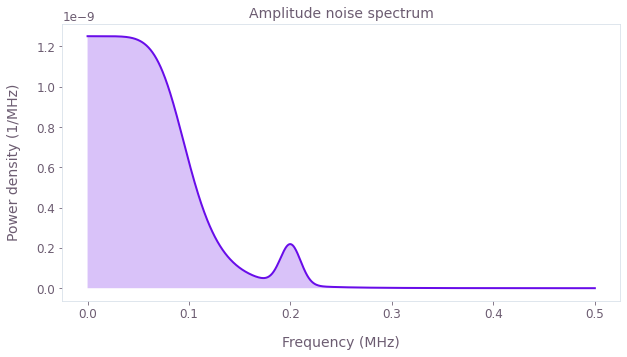

In [2]:
def gaussian(frequencies, offset, width):
    return np.exp(-0.5 * (frequencies - offset) ** 2 / width**2) / (
        np.sqrt(2 * np.pi) * width
    )


def pink(frequencies, frequency_cutoff, power):
    return frequency_cutoff ** (power - 1) / (
        frequencies**power + frequency_cutoff**power
    )


frequencies = np.linspace(0.0, 0.5e6, 1001)

amplitude_noise = 0.5e-11 * (
    25 * pink(frequencies=frequencies, frequency_cutoff=0.1 * 1e6, power=6)
    + gaussian(frequencies=frequencies, offset=0.2 * 1e6, width=10 * 1e3)
)

plt.plot(frequencies / 1e6, amplitude_noise * 1e6)
plt.fill_between(frequencies / 1e6, 0, amplitude_noise * 1e6, alpha=0.25)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.title("Amplitude noise spectrum")
plt.show()

### Determine (and visualize) probe controls that are sensitive to noise at different frequencies


In [3]:
# Define system parameters.
omega_max = 2 * np.pi * 250 * 1e6  # Hz
duration = 100 * 1e-6  # s
minimum_segment_duration = 1 * 1e-6  # s
pulse_count = 30

# Generate controls using in-built function for Gaussian probe controls.
probe_controls = [
    oc.new_modulated_gaussian_control(omega_max, minimum_segment_duration, duration, f)
    for f in np.linspace(0, 0.5 / minimum_segment_duration, pulse_count, endpoint=False)
]

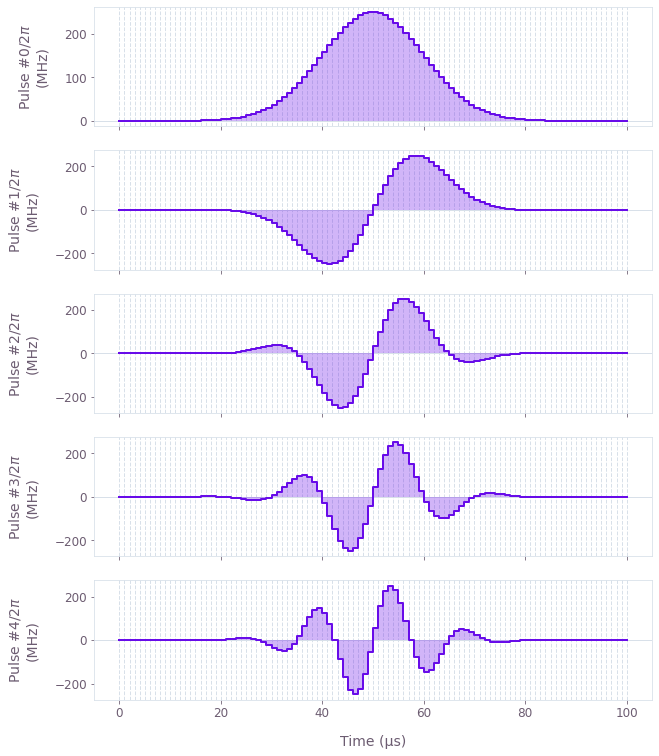

In [4]:
# Visualize first five pulses.
qv.plot_controls(
    {
        f"Pulse #{idx}": {
            "durations": pulse.durations,
            "values": pulse.rabi_rates * np.cos(pulse.azimuthal_angles),
        }
        for idx, pulse in enumerate(probe_controls[:5])
    }
)

### Collect experimental measurements

In this notebook we include code to simulate noisy measurements under the applied probe controls.  In a laboratory setting this would be replaced with experimental measurements

In [5]:
# Define noise parameters.
trajectory_count = 150
noise_segment_count = 100
frequency_step = np.diff(frequencies)[0]

graph = bo.Graph()

# Ensure all pulses use the same segmentation.
durations = probe_controls[0].durations
for pulse in probe_controls:
    assert np.array_equal(durations, pulse.durations)

# Create (pulse_count, T) array with the values of the controls.
values = np.array(
    [pulse.rabi_rates * np.cos(pulse.azimuthal_angles) for pulse in probe_controls]
)

# Create (pulse_count,)-batch of Pwcs representing the controls.
control = graph.pwc(durations=pulse.durations, values=values, time_dimension=-1)

# Create (trajectory_count, 1)-batch of Pwcs with the noises.
noise = graph.discretize_stf(
    stf=graph.random.colored_noise_stf_signal(
        power_spectral_density=amplitude_noise,
        frequency_step=frequency_step,
        batch_shape=(trajectory_count, 1),
    ),
    duration=np.sum(pulse.durations),
    segment_count=noise_segment_count,
)

# Create (trajectory_count, pulse_count)-batch of Pwcs with the Hamiltonians.
hamiltonian = 0.5 * (1 + noise) * control * graph.pauli_matrix("X")

# Calculate the (trajectory_count, pulse_count)-batch of infidelities.
graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    target=graph.target(operator=graph.pauli_matrix("I")),
    name="infidelities",
)

# Execute graph.
result = bo.execute_graph(graph, "infidelities")
infidelities = result["output"]["infidelities"]["value"]

# Calculate average/std of infidelities over the trajectories.
simulated_infidelities = np.mean(infidelities, axis=0)
simulated_infidelity_uncertainties = np.std(infidelities, axis=0, ddof=1) / np.sqrt(
    trajectory_count
)

Your task (action_id="1829121") has started.
Your task (action_id="1829121") has completed.


### Calculate (and visualize) filter functions for controls


In [6]:
# Filter functions.
sample_count = 200

graph = bo.Graph()

names = [f"filter_function_{idx}" for idx in range(len(probe_controls))]
for name, pulse in zip(names, probe_controls):
    shift = graph.pwc(
        durations=pulse.durations,
        values=pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles),
    )

    control_hamiltonian = graph.hermitian_part(shift * graph.pauli_matrix("X") / 2)

    graph.filter_function(
        control_hamiltonian=control_hamiltonian,
        noise_operator=control_hamiltonian,
        frequencies=frequencies,
        sample_count=sample_count,
        name=name,
    )

filter_functions = bo.execute_graph(graph, names, execution_mode="EAGER")["output"]

Your task (action_id="1829122") has started.
Your task (action_id="1829122") has completed.


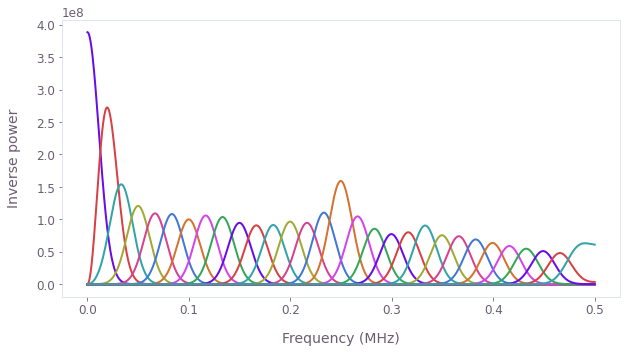

In [7]:
# Plot all filter functions.
for name in names:
    plt.plot(
        filter_functions[name]["frequencies"] * 1e-6,
        filter_functions[name]["inverse_powers"],
    )
plt.xlabel("Frequency (MHz)")
plt.ylabel("Inverse power")
plt.show()

### Reconstruct (and visualize) noise spectrum
Now we are ready to reconstruct the noise PSD by calling the function `boulderopal.noise_reconstruction.reconstruct`.
This function provides two different methods to perform reconstruction, namely the singular value decomposition (SVD) and convex optimization (CVX) methods.
You can check [the reference documentation](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/noise_reconstruction) for technical details about them.

In [8]:
filter_function_data = [
    bo.noise_reconstruction.FilterFunction(**filter_functions[name]) for name in names
]

# Perform reconstruction with singular value decomposition.
svd_result = bo.noise_reconstruction.reconstruct(
    filter_functions=[filter_function_data],
    infidelities=simulated_infidelities,
    infidelity_uncertainties=simulated_infidelity_uncertainties,
)

Your task (action_id="1829123") has started.
Your task (action_id="1829123") has completed.


In [9]:
# Configure convex optimization method.
cvx_method = bo.noise_reconstruction.ConvexOptimization(
    power_density_lower_bound=0,
    power_density_upper_bound=1,
    regularization_hyperparameter=1e-2,
)

# Perform reconstruction with convex optimization.
cvx_result = bo.noise_reconstruction.reconstruct(
    filter_functions=[filter_function_data],
    infidelities=simulated_infidelities,
    infidelity_uncertainties=simulated_infidelity_uncertainties,
    method=cvx_method,
)

Your task (action_id="1829124") has started.
Your task (action_id="1829124") has completed.


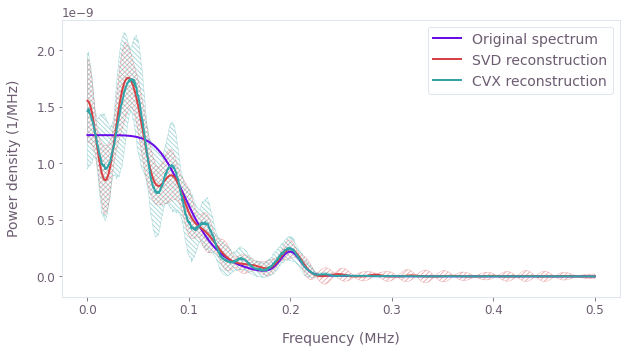

In [10]:
# Plot the noise spectral densities with their uncertainties.
plt.plot(frequencies * 1e-6, amplitude_noise * 1e6, label="Original spectrum")

fill_args = {"alpha": 0.4, "facecolor": "none", "linewidth": 0.5}

psd_svd = svd_result["output"][0]["psd"]
psd_u_svd = svd_result["output"][0]["uncertainties"]
plt.plot(frequencies * 1e-6, psd_svd * 1e6, label="SVD reconstruction")
plt.fill_between(
    frequencies * 1e-6,
    (psd_svd - psd_u_svd) * 1e6,
    (psd_svd + psd_u_svd) * 1e6,
    edgecolor=qv.QCTRL_STYLE_COLORS[1],
    hatch="/" * 5,
    **fill_args,
)

psd_cvx = cvx_result["output"][0]["psd"]
psd_u_cvx = cvx_result["output"][0]["uncertainties"]
plt.plot(frequencies * 1e-6, psd_cvx * 1e6, label="CVX reconstruction")
plt.fill_between(
    frequencies * 1e-6,
    (psd_cvx - psd_u_cvx) * 1e6,
    (psd_cvx + psd_u_cvx) * 1e6,
    edgecolor=qv.QCTRL_STYLE_COLORS[2],
    hatch="\\" * 5,
    **fill_args,
)
plt.legend()
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.show()

### Summary

We see that the reconstructed noise spectral density matches the original noise spectral density reasonably closely, especially in terms of the large-scale trends. By taking more precise infidelity data (with lower uncertainties) we would see an even closer match between the two spectra. We have thus demonstrated how to use Boulder Opal to reconstruct the noise spectral density of an amplitude noise process affecting a single qubit system. Similar procedures may be employed to reconstruct noise spectral densities for other noise processes (for example stochastic dephasing noises) in other types of systems.